In [3]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import random
import sys
import io
import os
import requests

In [16]:
r = requests.get("https://raw.githubusercontent.com/devkotasawal1/Poem-Generator/master/lspd.txt")
raw_text = r.text
print(raw_text[0:1000])

नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,
मनको वनमा ननिभ्ने गरी विरह जलाई !
ननिभ्ने गरी विरह जलाई,
लोचनका तारा ! हे मेर प्यारा ! यो जोति  बिलाए !
के भनूँ? भन्ने म केही थिइन  विष नै पिलाए !
प्यारा ! विष नै पिलाए !
मनको कुरा गलामा अड्छ, अड्कन्छ गलामा,
यो मेरो मुटु पचासबाजी धड्कन्छ पलामा ।
यो छाती मेरो चिरेर खोली नजर गराए,
त्यो मन केही फर्कंदो होला, तस्विर खुलाए
आँसुमा खस्छ मनको टुक्रा यो आँसु बोल्दैन,
मनको कुरा मनमै बस्छ, छातिले खोल्दैन,
प्यारा ! आँसुले बोल्दैन !
हे मेरी मुना ! नभन त्यसो, जूनमा फुलेकी !
फर्कन्छु फेरि म चाँडै भन्ने किन हो भुलेकी ?
म बीसै दिन बसुँला ल्हासा, बाटामा बीसै दिन्,
चखेवा फेरी आउँछ उडी बिहान कुनै दिन्,
प्यारी ! भेटको बडा दिन !
कि मरिछाड्यो, कि गरिछाड्यो मर्दको इरादा,
नहाल प्यारि ! बाटामा मेरो आँसुको यो बाधा ।
अनार दाना दाँतका लहर खोलेर हाँसन्,
तिमीले हाँसे म हाँक्न सक्छु ईन्द्रको आसन ।
प्यारी ! बिदामा हाँसन 
हे मेरा राम ! हे मेरा कृष्ण ! जङ्गल, पहाड,
भीरका भोटे, वनका जन्तु, गाइको आहार !
रातमा सुर्जे, बिदामा हाँसो कसरी मिलाऊँ ?
हजुरको गाथ, हजुरको माथ प्रीतिले समाऊँ 

In [17]:
print('corpus length:', len(raw_text))

chars = sorted(list(set(raw_text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

corpus length: 119162
total chars: 74


In [18]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(raw_text) - maxlen, step):
    sentences.append(raw_text[i: i + maxlen])
    next_chars.append(raw_text[i + maxlen])
print('Trainable sequences:', len(sentences))

Trainable sequences: 39708


In [19]:
sentences[0:10]

['नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,',
 'डी जानोस् हे मेरा प्राण ! अकेली मलाई,\nमन',
 'जानोस् हे मेरा प्राण ! अकेली मलाई,\nमनको ',
 'ोस् हे मेरा प्राण ! अकेली मलाई,\nमनको वनम',
 ' हे मेरा प्राण ! अकेली मलाई,\nमनको वनमा न',
 ' मेरा प्राण ! अकेली मलाई,\nमनको वनमा ननिभ',
 'रा प्राण ! अकेली मलाई,\nमनको वनमा ननिभ्ने',
 'प्राण ! अकेली मलाई,\nमनको वनमा ननिभ्ने गर',
 'ाण ! अकेली मलाई,\nमनको वनमा ननिभ्ने गरी व',
 '! अकेली मलाई,\nमनको वनमा ननिभ्ने गरी विरह']

In [20]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [21]:
print(f"{x.shape} {y.shape}")

(39708, 40, 74) (39708, 74)


In [22]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               103936    
_________________________________________________________________
dense_1 (Dense)              (None, 74)                9546      
Total params: 113,482
Trainable params: 113,482
Non-trainable params: 0
_________________________________________________________________


In [24]:
def sample(preds, temp=1.0): #softmax 
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temp
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [13]:
epochs = 40

loss = []

base_dir = 'generated_text'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    history = model.fit(x, y, batch_size=128, epochs=1)
    loss.append(history.history['loss'][0])
    
    epoch_dir = os.path.join(base_dir, 'epoch_' + str(epoch))
    if not os.path.isdir(epoch_dir):
        os.mkdir(epoch_dir)

    start_idx = np.random.randint(0, len(raw_text) - maxlen - 1)
    seed_text = raw_text[start_idx:start_idx + maxlen]
    for temp in [0.2, 0.5, 1.0, 1.3]:
        generated_text = seed_text
        temp_file = 'epoch' + str(epoch) + '_temp' + str(temp) + '.txt'
        file = open(os.path.join(epoch_dir, temp_file), 'w')
        file.write(generated_text)
        
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for j, char in enumerate(generated_text):
                sampled[0, j, char_indices[char]] = 1.
            
            preds = model.predict(sampled, verbose=0)[0]
            pred_idx = sample(preds,temp)
            next_char = chars[pred_idx]
            
            generated_text += next_char
            generated_text = generated_text[1:]
            
            file.write(next_char)
        print('Temp ' + str(temp) + " done.")
        file.close()

Epoch 1
311/311 [==============================] - 37s 118ms/step - loss: 2.8515
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 2
311/311 [==============================] - 35s 114ms/step - loss: 2.4596
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 3
311/311 [==============================] - 37s 118ms/step - loss: 2.2872
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 4
311/311 [==============================] - 36s 117ms/step - loss: 2.1525
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 5
311/311 [==============================] - 36s 116ms/step - loss: 2.0309
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 6
311/311 [==============================] - 36s 116ms/step - loss: 1.9195
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 7
311/311 [==============================] - 35s 114ms/step - loss: 1.8238
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 8
311/3

In [33]:
import matplotlib.pyplot as plt

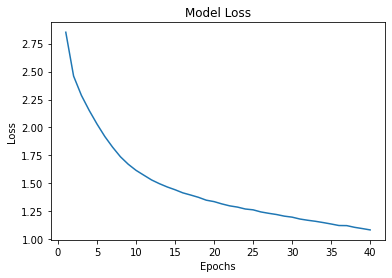

In [34]:
plt.plot([i for i in range(1, epochs+1)], loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

In [35]:
model.save('keras.h5')

In [ ]:
!pip install tensorflowjs 

In [37]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

In [39]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 70%)
  adding: model/group1-shard1of1.bin (deflated 8%)


In [40]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
model.save('TFmodel')

INFO:tensorflow:Assets written to: TFmodel/assets


In [66]:
!zip -r TFmodel.zip TFmodel 

  adding: TFmodel/ (stored 0%)
  adding: TFmodel/assets/ (stored 0%)
  adding: TFmodel/saved_model.pb (deflated 91%)
  adding: TFmodel/variables/ (stored 0%)
  adding: TFmodel/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: TFmodel/variables/variables.index (deflated 39%)


In [83]:
files.download('TFmodel.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r generated_text.zip generated_text

In [84]:
files.download('generated_text.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>